In [29]:
from Functions import *

In [2]:
# I get warnings when precision is 0 in bad classifiers
import warnings; warnings.simplefilter('ignore')

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

**Loading the Data**

In [4]:
data = load_data()
# dropping my obvious outlier
data = remove_outliers(data)

### My Basic Preprocessing Pipeline

There are a number of preprocessing steps I attempt with each model before adding the classifier. My basic pipeline is as follows: 

1. *Imputer*: Imputes values for observations with null values. My default strategy is 'median'. 
<br><br>
2. *Resampling*: There are very few POIs relative to the total number of observations. Most classifiers struggle with highly imbalanced classes like this. I use an implementation of the SMOTE algorithm to artificially generate new POI observations in order to balance my dataset. 
<br><br>
3. *Feature Selection*: In order to eliminate noise and maintain a parsimonious model, I want to keep only the most valuable features. I used Sklearn's SelectKBest with ANOVA F-scores as the scoring metric. It limits me to "k" features with highest F-scores (A metric for how well the feature separates my classes). 
<br><br>
4. *Feature Scaling*: A number of my features are on wildly different scales which means that some algorithms will overweight certain features when determining the class. My default scaler standardizes all my features (set mean to 0 and std to 1) to account for this. 
<br><br>
5. *Principal Component Analysis*: PCA does a number of things. First it can help reduce noise by finding combinations of features that explain the most variation in my data so I can use a smaller number of features when actually fitting the model. Second it projects all features onto orthogonal axis so I don't need to worry about issues of multicollinearity which can affect the performance of some models.  

In [5]:
for step, impl in base_pipeline:
    print('Step:', step)
    print('Implementation:', impl)
    print('=====================\n')

Step: imputer
Implementation: Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

Step: resampling
Implementation: SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=None, ratio='auto', svm_estimator=None)

Step: selection
Implementation: SelectKBest(k=10, score_func=<function f_classif at 0x0000014CBE32A598>)

Step: scaler
Implementation: StandardScaler(copy=True, with_mean=True, with_std=True)

Step: pca
Implementation: PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)



### Pipeline Tuning

Prior to tuning the hyperparameters, I use grid search cross validation to make sure I am using the optimal pipeline permuation for each model. I chose to keep these separate from the hyperparameter tuning to keep the number of permutations I had to test from getting out of control. The parameters I adjust to create each pipeline permuation are:

1. *Feature Scaling*: I try each pipeline with and without feature scaling. 
<br><br>
2. *Number of Features in Feature Selection*: I try a number of different values for k (The # of features to keep)
<br><br>
3. *PCA*: I try the pipeline with no PCA and PCA with a number of different components being kept. 

In [6]:
for param, vals in base_param_grid.items():
    print('Parameter:', param)
    print('Possible Values:')
    pprint(vals)
    print('=====================\n')

Parameter: scaler
Possible Values:
[None, StandardScaler(copy=True, with_mean=True, with_std=True)]

Parameter: selection__k
Possible Values:
[7, 10, 15]

Parameter: pca
Possible Values:
[None,
 PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False),
 PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False),
 PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)]



In [7]:
X, y = data[all_features], data.poi

## Model Selection

I tried a variety of different classifiers, using GridSearchCV to find the optimal pipeline for each one. Displayed below are the scores for the model, a confusion matrix, the optimal pipeline parameters, and information about which features were used. 

**Scores Explained:** I use several metrics to evaluate the model
1. *Accuracy*: The proportion of correct classifications
2. *Recall*: The proportion of POI's identified
3. *Precision*: A measure of how discerning the model is
4. *F1*: A combination of precision and recall which givens an overall measure of how effective the model is. 

*Note*: In all models GridSearchCV is optimizing for precision as I had difficulty getting that over the required threshhold. 

#### Logistic Regression

In [36]:
clf = [('clf', LogisticRegression())]
model = imb_pipeline(base_pipeline + clf)
param_grid = base_param_grid.copy()


SCORES:

Average Accuracy: 0.783865248227
Average Precision:  0.313223581974
Average Recall: 0.561111111111
Average F1:  0.392974745986

Pipeline Parameters:
{'pca': PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False),
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'selection__k': 15}

Retained Features:

exercised_stock_options
total_stock_value
long_term_incentive
deferred_income
shared_receipt_with_poi
bonus
salary
restricted_stock
deferral_payments
from_poi_to_this_person
from_this_person_to_poi
expenses
director_fees
from_messages
restricted_stock_deferred
Number of principal components retained: 2


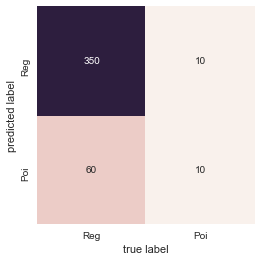

In [37]:
lr_grid = evaluate_model(model, param_grid, X, y, optimize='precision')

Results look pretty good here. Both recall and precision are over .3, which were the minimum values set for the project. 

#### K Nearest Neighbors

In [42]:
clf = [('clf', KNeighborsClassifier())]
model = imb_pipeline(base_pipeline + clf)
param_grid = base_param_grid.copy()


SCORES:

Average Accuracy: 0.723005319149
Average Precision:  0.253582040594
Average Recall: 0.577777777778
Average F1:  0.348220064969

Pipeline Parameters:
{'pca': PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False),
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'selection__k': 7}

Retained Features:

exercised_stock_options
total_stock_value
long_term_incentive
deferred_income
shared_receipt_with_poi
bonus
salary
Number of principal components retained: 2


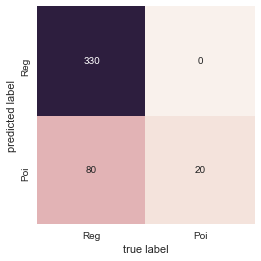

In [43]:
grid = evaluate_model(model, param_grid, X, y, optimize='precision')

Although my F1 is similar to Logistic Regression, my precision is below the .3 threshold expected for the project. 

#### SVM

In [46]:
clf = [('clf', SVC())]
model = imb_pipeline(base_pipeline + clf)
# extra_params = {'clf__kernel': ['linear', 'rbf']}
param_grid = base_param_grid.copy()
# param_grid.update(extra_params)


SCORES:

Average Accuracy: 0.732904846336
Average Precision:  0.266361182104
Average Recall: 0.622222222222
Average F1:  0.370016522648

Pipeline Parameters:
{'pca': PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False),
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'selection__k': 10}

Retained Features:

exercised_stock_options
total_stock_value
long_term_incentive
deferred_income
shared_receipt_with_poi
bonus
salary
restricted_stock
deferral_payments
from_poi_to_this_person
Number of principal components retained: 2


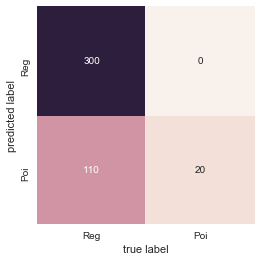

In [47]:
grid = evaluate_model(model, param_grid, X, y, optimize='precision')

Great recall, low precision. I'm not going to move forward with this model because it takes so long to train. 

#### Naive Bayes

In [48]:
clf = [('clf', GaussianNB())]
model = imb_pipeline(base_pipeline + clf)
param_grid = base_param_grid.copy()


SCORES:

Average Accuracy: 0.818823877069
Average Precision:  0.350695045695
Average Recall: 0.388888888889
Average F1:  0.351470822206

Pipeline Parameters:
{'pca': None, 'scaler': None, 'selection__k': 7}

Retained Features:

exercised_stock_options
total_stock_value
long_term_incentive
deferred_income
shared_receipt_with_poi
bonus
salary


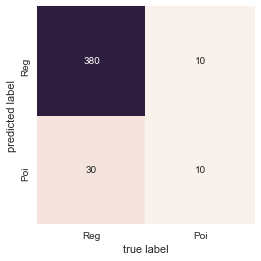

In [49]:
nb_grid = evaluate_model(model, param_grid, X, y, optimize='f1')

Recall is much worse than my other classifiers, but precision performed great. 

#### Decision Tree

In [57]:
clf = [('clf', DecisionTreeClassifier())]
model = imb_pipeline(base_pipeline + clf)
param_grid = base_param_grid.copy()


SCORES:

Average Accuracy: 0.774793144208
Average Precision:  0.242785322521
Average Recall: 0.307777777778
Average F1:  0.255021478228

Pipeline Parameters:
{'pca': None, 'scaler': None, 'selection__k': 7}

Retained Features:

exercised_stock_options
total_stock_value
long_term_incentive
deferred_income
shared_receipt_with_poi
bonus
salary


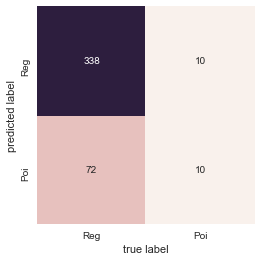

In [58]:
grid = evaluate_model(model, param_grid, X, y, optimize='precision')

### Ensemble Methods

Next I'll look at some ensemble classifiers

#### Random Forest

In [52]:
clf = [('clf', RandomForestClassifier())]
model = imb_pipeline(base_pipeline + clf)
param_grid = base_param_grid.copy()


SCORES:

Average Accuracy: 0.80176713948
Average Precision:  0.248137436637
Average Recall: 0.291111111111
Average F1:  0.259253003962

Pipeline Parameters:
{'pca': None, 'scaler': None, 'selection__k': 10}

Retained Features:

exercised_stock_options
total_stock_value
long_term_incentive
deferred_income
shared_receipt_with_poi
bonus
salary
restricted_stock
deferral_payments
from_poi_to_this_person


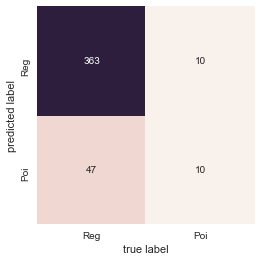

In [53]:
grid = evaluate_model(model, param_grid, X, y, optimize='precision')

#### Ada Boost

In [54]:
clf = [('clf', AdaBoostClassifier())]
model = imb_pipeline(base_pipeline + clf)
param_grid = base_param_grid.copy()


SCORES:

Average Accuracy: 0.805629432624
Average Precision:  0.307463462463
Average Recall: 0.344444444444
Average F1:  0.30521293779

Pipeline Parameters:
{'pca': None, 'scaler': None, 'selection__k': 10}

Retained Features:

exercised_stock_options
total_stock_value
long_term_incentive
deferred_income
shared_receipt_with_poi
bonus
salary
restricted_stock
deferral_payments
from_poi_to_this_person


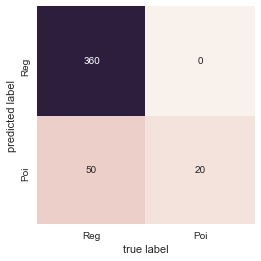

In [55]:
grid = evaluate_model(model, param_grid, X, y, optimize='precision')

## Careful Tuning

Tuning the hyperparameters in selected models. I chose to move forward only with logistic regression and naive bayes as those models had the best performance prior to tuning. 

### Naive Bayes

In [59]:
clf = [('clf', GaussianNB())]
model = imb_pipeline(base_pipeline + clf)

In [60]:
param_grid = {}
for k, v in nb_grid.best_params_.items():
    if v == 'None':
        v = None
    param_grid[k] = [v]

In [61]:
param_grid['clf__priors'] = [None, [.5, .5]]


SCORES:

Average Accuracy: 0.818823877069
Average Precision:  0.350695045695
Average Recall: 0.388888888889
Average F1:  0.351470822206

Pipeline Parameters:
{'clf__priors': None, 'pca': None, 'scaler': None, 'selection__k': 7}

Retained Features:

exercised_stock_options
total_stock_value
long_term_incentive
deferred_income
shared_receipt_with_poi
bonus
salary


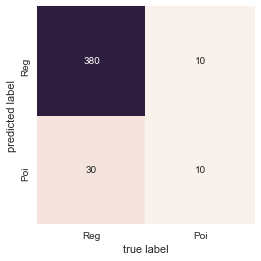

In [62]:
grid = evaluate_model(model, param_grid, X, y, optimize='f1')

There aren't a lot of hyperparameters to tune here, the model still performs worse than logistic regression. 

### Logistic Regression

In [63]:
clf = [('clf', LogisticRegression())]
model = imb_pipeline(base_pipeline + clf)

In [64]:
param_grid = {}
for k, v in lr_grid.best_params_.items():
    if v == 'None':
        v = None
    param_grid[k] = [v]

In [65]:
param_grid['clf__penalty'] = ['l1', 'l2']
param_grid['clf__C'] = [0.1, 1, 10, 100, 1000, 5000]


SCORES:

Average Accuracy: 0.805511229314
Average Precision:  0.335045880046
Average Recall: 0.488888888889
Average F1:  0.381318883502

Pipeline Parameters:
{'clf__C': 0.1,
 'clf__penalty': 'l1',
 'pca': PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False),
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'selection__k': 15}

Retained Features:

exercised_stock_options
total_stock_value
long_term_incentive
deferred_income
shared_receipt_with_poi
bonus
salary
restricted_stock
deferral_payments
from_poi_to_this_person
from_this_person_to_poi
expenses
director_fees
from_messages
restricted_stock_deferred
Number of principal components retained: 2


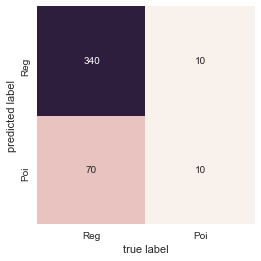

In [66]:
grid = evaluate_model(model, param_grid, X, y, optimize='precision')

This is my best and final model. Below I pickle individual components for submission with Udacity. 

In [96]:
import pickle

In [97]:
pickle.dump(data, open('my_dataset.pkl', 'wb'))
pickle.dump(grid.best_estimator_, open('my_classifier.pkl', 'wb'))
pickle.dump(all_features, open('my_feature_list.pkl', 'wb'))